In [78]:
import numpy as np
import astropy.units 
import astropy.time
import sdss_access
import fitsio
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import os
# import sdss_semaphore.targeting
from sdss_access import Path
from sdss_access import HttpAccess
# from SEDFit.sed import SEDFit
from scipy.interpolate import interp1d

In [79]:
hdul = fits.open('g28-37-ApogeeNet.fits')
hdul = hdul[1].data
t = Table(hdul)

In [80]:
# iso = np.genfromtxt(
#    "cleaned_isodata.txt",
#    comments= '#',
#    names=True
#)

In [81]:
app_mag = t['g_mag']
teff = t['teff']
plx  = t['plx']
ra = t['ra']
dec = t['dec']
logg = t['logg']
ebv = t['ebv']
plx_error = t['e_plx']

In [82]:
# extinction and magnitudes
Ag_sdss  = 2.74 * ebv

# Base subset: positive parallaxes ONLY
idx_pos = (plx > 0)

# Slice everything to the SAME base space
app_mag_pos = app_mag[idx_pos]
teff_pos    = teff[idx_pos]
plx_pos     = plx[idx_pos]
Ag_sdss_pos = Ag_sdss[idx_pos]

app_mag0  = app_mag_pos - Ag_sdss_pos # dereddened apparent G

# Absolute G mag (assuming plx is in mas)
abs_mag = app_mag_pos - 10 + 5 * np.log10(plx_pos)
abs_mag0 = app_mag0 - 10 + 5*np.log10(plx_pos)   # dereddened


In [83]:
# distance (pc) in the same base space
dist_pc = 1000.0 / plx_pos

In [84]:
# x=SEDFit(ra[0],dec[0],1)
# x.addguesses(r=[1],teff=teff[0],logg=logg[0], feh = 0.0)
# x.fit(fitteff = False, fitlogg = False, fitfeh = False, fitdist = False)
# x.makeplot()
# x.sed['model']=x.mags
# x.sed

In [85]:
# ---- Second filter: parallax range, but in the SAME space ----
plx_mask = (plx_pos > 0.15) & (plx_pos < 0.25)

subset_abs_mag = abs_mag[plx_mask]
subset_abs_mag0 = abs_mag0[plx_mask] #dereddened
subset_teff    = teff_pos[plx_mask]

In [86]:
# 1) Load & plot PARSEC isochrones (1–20 Myr)
#iso_cols = [
#    "Zini", "MH", "logAge", "Mini", "int_IMF", "Mass", "logL", "logTe", "logg", "label",
#    "McoreTP", "C_O", "period0", "period1", "period2", "period3", "period4", "pmode",
#    "Mloss", "tau1m", "X", "Y", "Xc", "Xn", "Xo", "Cexcess", "Z", "mbolmag", "Gmag", 
#    "G_BPmag", "G_RPmag"
#]

#iso = np.genfromtxt(
#    "cleaned_isodata.txt",
#    comments= '#',
#    names=iso_cols
#)

#Teff_iso = 10**iso['logTe']
#G_iso  = iso['Gmag']
#ages_iso = iso['logAge']
#mass_iso = iso['Mini']

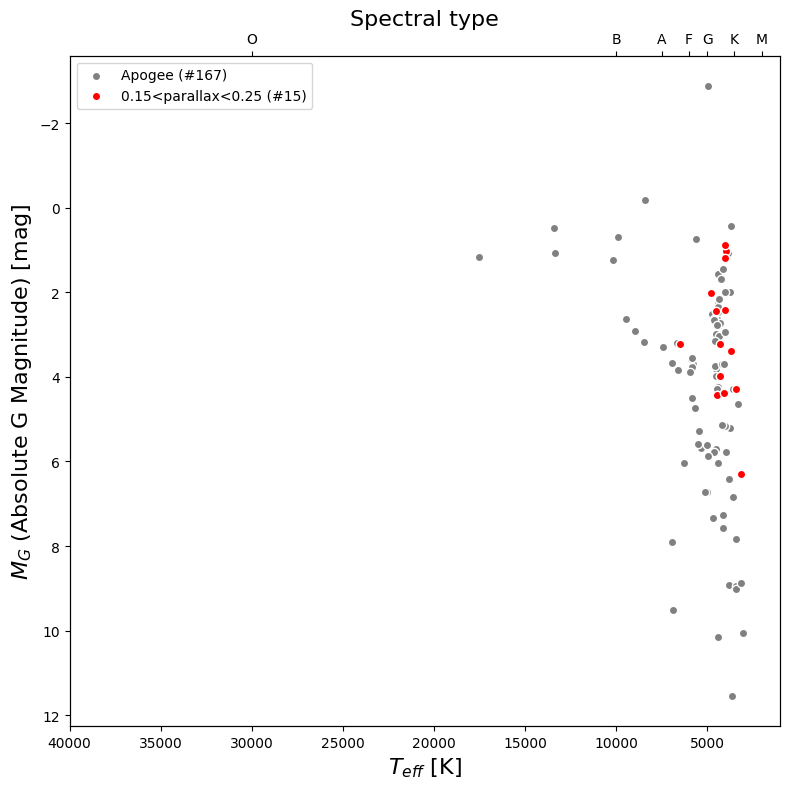

In [87]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the isochrones
#for la in np.unique(ages_iso):
#    sel = ages_iso == la
#    order = np.argsort(mass_iso[sel])
#    ax.plot(
#        Teff_iso[sel][order],
#        G_iso[sel][order],
#        lw=1,
#        label=f"{10**la/1e6:.0f} Myr"
#    )

# Mark masses on the 10 Myr isochrone
#targetAge = 1e7
#logAges = np.unique(ages_iso)
#targetLogA = np.log10(targetAge)
#la0 = logAges[np.argmin(np.abs(logAges - targetLogA))]
#sel0 = ages_iso == la0

#M0 = iso['Mass'][sel0]
#Teff0 = Teff_iso[sel0]
#G0 = G_iso[sel0]

#order0 = np.argsort(Teff0)
#Teff0 = Teff0[order0]
#G0 = G0[order0]
#M0 = M0[order0]

#targets = [2, 5, 10, 15]  # in M_sun
#for target in targets:
#    idx = np.argmin(np.abs(M0 - target))
#    ax.scatter(
#        Teff0[idx], G0[idx],
#        marker='*', s=100, c='k', zorder=5
#    )
#    ax.text(
#        Teff0[idx] * 1.05, G0[idx],
#        f"{M0[idx]:.0f} $M_\\odot$",
#        fontsize=12, ha='right', va='center'
#    )

# Spectral type axis
ax.set_xlim(1000, 40000) 
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

spectral_temps = [30000, 10000, 7500, 6000, 5000, 3500, 2000]
spectral_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

ax2.set_xticks(spectral_temps)
ax2.set_xticklabels(spectral_types, fontsize=10)
ax2.set_xlabel('Spectral type', labelpad=5, fontsize = 16)
ax2.invert_xaxis()

# Plot your stars
ax.scatter(teff_pos, abs_mag, color='gray', edgecolor='w', label=f'Apogee (#{len(teff)})')
ax.scatter(subset_teff, subset_abs_mag, color='red', edgecolor='w',
           label=f'0.15<parallax<0.25 (#{len(subset_teff)})')

# Axis settings
ax.set_xlabel("$T_{eff}$ [K]", fontsize=16)
ax.set_ylabel("$M_G$ (Absolute G Magnitude) [mag]", fontsize=16)
ax.tick_params(axis='both', labelsize=10)
ax.invert_xaxis()  
ax.invert_yaxis()
ax.legend(fontsize=10)

fig.tight_layout()
plt.savefig('g28_hrdiagram.png')
plt.show()

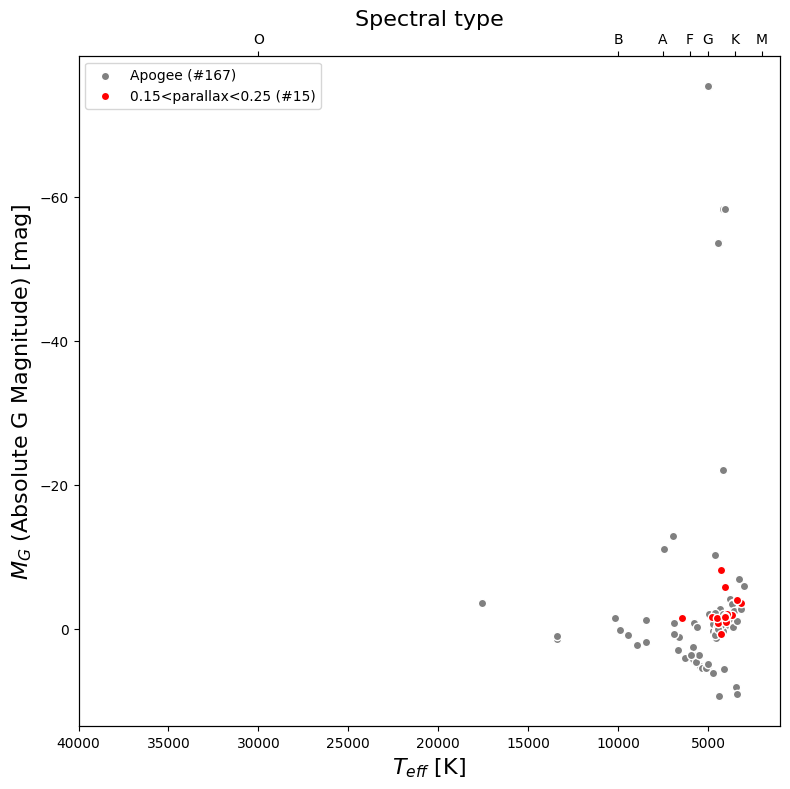

In [88]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the isochrones
#for la in np.unique(ages_iso):
#    sel = ages_iso == la
#    order = np.argsort(mass_iso[sel])
#    ax.plot(
#        Teff_iso[sel][order],
#        G_iso[sel][order],
#        lw=1,
#        label=f"{10**la/1e6:.0f} Myr"
#    )

# Mark masses on the 10 Myr isochrone
#targetAge = 1e7
#logAges = np.unique(ages_iso)
#targetLogA = np.log10(targetAge)
#la0 = logAges[np.argmin(np.abs(logAges - targetLogA))]
#sel0 = ages_iso == la0

#M0 = iso['Mass'][sel0]
#Teff0 = Teff_iso[sel0]
#G0 = G_iso[sel0]

#order0 = np.argsort(Teff0)
#Teff0 = Teff0[order0]
#G0 = G0[order0]
#M0 = M0[order0]

#targets = [2, 5, 10, 15]  # in M_sun
#for target in targets:
#    idx = np.argmin(np.abs(M0 - target))
#    ax.scatter(
#        Teff0[idx], G0[idx],
#        marker='*', s=100, c='k', zorder=5
#    )
#    ax.text(
#        Teff0[idx] * 1.05, G0[idx],
#        f"{M0[idx]:.0f} $M_\\odot$",
#        fontsize=12, ha='right', va='center'
#    )

# Spectral type axis
ax.set_xlim(1000, 40000) 
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

spectral_temps = [30000, 10000, 7500, 6000, 5000, 3500, 2000]
spectral_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

ax2.set_xticks(spectral_temps)
ax2.set_xticklabels(spectral_types, fontsize=10)
ax2.set_xlabel('Spectral type', labelpad=5, fontsize = 16)
ax2.invert_xaxis()

# Plot your stars
ax.scatter(teff_pos, abs_mag0, color='gray', edgecolor='w', label=f'Apogee (#{len(teff)})')
ax.scatter(subset_teff, subset_abs_mag0, color='red', edgecolor='w',
           label=f'0.15<parallax<0.25 (#{len(subset_teff)})')

# Axis settings
ax.set_xlabel("$T_{eff}$ [K]", fontsize=16)
ax.set_ylabel("$M_G$ (Absolute G Magnitude) [mag]", fontsize=16)
ax.tick_params(axis='both', labelsize=10)
ax.invert_xaxis()  
ax.invert_yaxis()
ax.legend(fontsize=10)

fig.tight_layout()
plt.savefig('velac_hrdiagram.png')
plt.show()

In [89]:
plx_lower, plx_upper = 1.0, 1.25

In [151]:
under = plx < plx_lower
over  = plx > plx_upper

# Compute the sigma deviation **only when it's outside**
sigma_dev = np.zeros_like(plx)

# below the lower bound
sigma_dev[under] = (plx_lower - plx[under]) / plx_error[under]

# above the upper bound
sigma_dev[over] = (plx[over] - plx_upper) / plx_error[over]

In [153]:
mask_1sigma = (sigma_dev > 0) & (sigma_dev <= 1)
mask_2sigma = (sigma_dev > 1) & (sigma_dev <= 2)
mask_3sigma = (sigma_dev > 2) & (sigma_dev <= 3)
mask_beyond = sigma_dev > 3

In [90]:
subset_teff = teff[plx_mask]
subset_dereddened_gmag_sdss = dereddened_gmag_sdss[plx_mask]

b_teff = (teff > 10000) & (teff < 30000)

selected_teff = teff[b_teff]
selected_gmag = dereddened_gmag_sdss[b_teff]

a_teff = (teff > 7500) & (teff < 10000)

selected_ateff = teff[a_teff]
selected_agmag = dereddened_gmag_sdss[a_teff]

fig, ax = plt.subplots(figsize=(8, 8))

iso_colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#d62728", "#9467bd"]

for i, la in enumerate(np.unique(ages_iso)):
    #For each age la, sel = ages_iso == la filters the data to just that isochrone.
    sel  = ages_iso == la
    order = np.argsort(mass_iso[sel])
    ax.plot(
        Teff_iso[sel][order],
        G_iso[sel][order],
        lw=1, 
        c = iso_colors[i],
        label=f"{10**la/1e6:.0f} Myr"
    )

targetAge = 1e7
logAges  = np.unique(ages_iso)
targetLogA = np.log10(targetAge)
la0    = logAges[np.argmin(np.abs(logAges - targetLogA))]
sel0    = ages_iso == la0

# get the *current* mass at 10 Myr
M0   = iso['Mass'][sel0]
Teff0 = Teff_iso[sel0]
G0   = G_iso[sel0]

# sort by Teff
order0 = np.argsort(Teff0)
Teff0 = Teff0[order0]
G0   = G0[order0]
M0   = M0[order0]

# choose which masses to label
targets = [2, 5, 10, 15]  # in M_sun
for target in targets:
    # find the closest point in mass
    idx = np.argmin(np.abs(M0 - target))
    ax.scatter(
        Teff0[idx], G0[idx],
        marker='*', s=100, c='k', zorder=5
    )
    ax.text(
        Teff0[idx] * 1.05, G0[idx],
        f"{M0[idx]:.0f} $M_\\odot$",
        fontsize=12, ha='right', va='center'
    )

ax.set_xlim(1000, 40000) 
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

spectral_temps = [30000, 10000, 7500, 6000, 5000, 3500, 2000]
spectral_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

ax2.set_xticks(spectral_temps)
ax2.set_xticklabels(spectral_types, fontsize=10)
ax2.set_xlabel('Spectral type', labelpad=5, fontsize = 16)
ax2.invert_xaxis()
    
# ax.scatter(teff, dereddened_gmag_sdss, color = 'gray', edgecolor = 'w', label = f'All Apogee DR17 within 100 arcmins (#{len(dereddened_gmag_sdss)})')
ax.scatter(subset_teff, subset_dereddened_gmag_sdss, color = 'red', label = f'1.00<parallax<1.25 [mas] (#{len(subset_dereddened_gmag_sdss)})')

ax.scatter(teff[mask_1sigma], dereddened_gmag_sdss[mask_1sigma], 
           c="#fff7bc", label='1σ', s=30)

ax.scatter(teff[mask_2sigma], dereddened_gmag_sdss[mask_2sigma], 
           c="#fec44f", label='2σ', s=30)

ax.scatter(teff[mask_3sigma], dereddened_gmag_sdss[mask_3sigma], 
           c="#fe9929", label='3σ', s=30)

ax.scatter(teff[mask_beyond], dereddened_gmag_sdss[mask_beyond], 
           c= "#cc4c02", label='>3σ', s=30)

ax.scatter(
    selected_teff,
    selected_gmag,
    facecolors='none',
    edgecolors="#17becf",
    linewidths=1.5,
    s=35,
    label=f'30,000 > Teff > 10,000 K #{len(selected_teff)}'
)

ax.scatter(
    selected_ateff,
    selected_agmag,
    facecolors='none',
    edgecolors= "#3182bd",
    linewidths=1.5,
    s=35,
    label=f'10,000 > Teff > 7,500 K #{len(selected_ateff)}'
)
                         
ax.set_xlabel("$T_{eff}$ [K]", fontsize = 16)
ax.set_ylabel("$M_G$ (Absolute dereddened G Magnitude with Astra)", fontsize = 16)
ax.tick_params(axis='both', labelsize=10)
ax.set_ylim(-11, 10)
ax.invert_xaxis()
ax.invert_yaxis()
ax.legend(fontsize = 10)
fig.tight_layout()
plt.savefig('dereddened_hr_diagram_sdss.png')
plt.show()

[ERROR]: Traceback (most recent call last):
  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_53609/3859214759.py", line 1, in <module>
    subset_teff = teff[plx_mask]
                  ~~~~^^^^^^^^^^
  File "astropy/table/_column_mixins.pyx", line 79, in astropy.table._column_mixins._ColumnGetitemShim.__getitem__
  File "astropy/table/_column_mixins.pyx", line 62, in astropy.table._column_mixins.base_getitem
  File "astropy/table/_column_mixins.pyx", line 74, in astropy.table._column_mixins.column_getitem
IndexError: boolean index did not match indexed array along dimension 0; dimension is 167 but corresponding boolean dimension is 108



In [167]:
print(np.unique(ages_iso))

[6.      6.69897 7.      7.17609 7.30103]


In [189]:
age_iso = [6.]

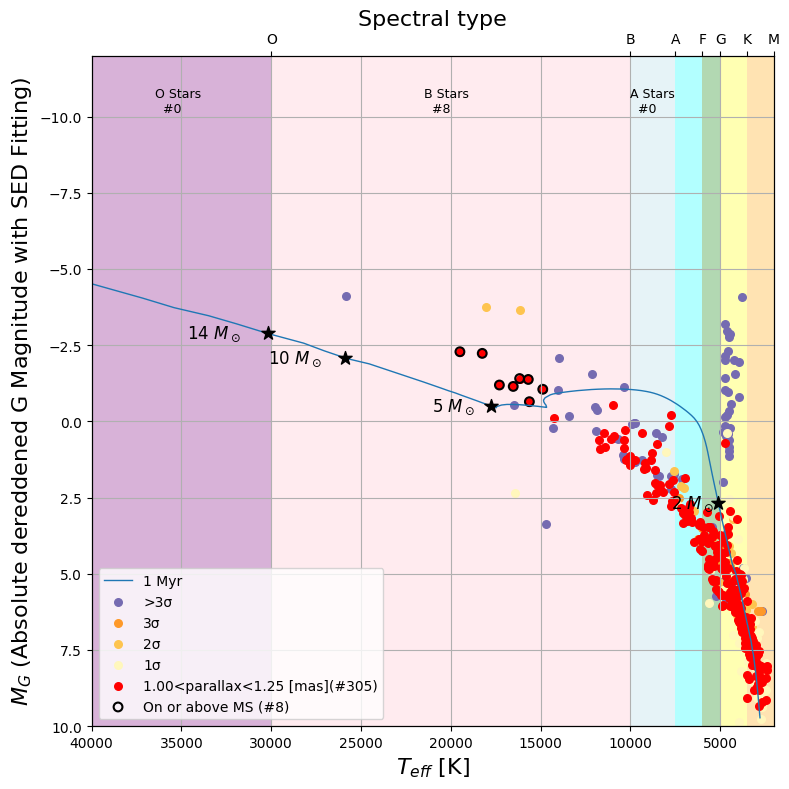

In [191]:
subset_teff = teff[plx_mask]
subset_dereddened_gmag_fitted = dereddened_gmag_fitted[plx_mask]

b_teff = (teff > 10000) & (teff < 30000) & (plx > 1.00) & (plx < 1.25)

selected_teff = teff[b_teff]
selected_gmag = dereddened_gmag_fitted[b_teff]

a_teff = (teff > 7500) & (teff < 10000) & (plx > 1.00) & (plx < 1.25)

selected_ateff = teff[a_teff]
selected_agmag = dereddened_gmag_fitted[a_teff]

temp_mask = (teff > 7500) & (plx > 1.00) & (plx < 1.25) 
# above_iso_mask = dereddened_gmag_fitted < 1.0

mask_above_1iso = temp_mask & (dereddened_gmag_fitted < -0.6)

mask_above_5iso = temp_mask & (dereddened_gmag_fitted < 1.0)

mask_above_20iso = temp_mask & (dereddened_gmag_fitted < 2.4)

fig, ax = plt.subplots(figsize=(8, 8))
ax.grid()

ax.fill_betweenx(
    y=[-12, 10],  
    x1=30000,     
    x2=40000,     
    facecolor='purple',
    alpha=0.3
)

ax.fill_betweenx(
    y=[-12, 10],  
    x1=10000,     
    x2=30000,     
    facecolor='pink',
    alpha=0.3
)

ax.fill_betweenx(
    y=[-12, 10],  
    x1=7500,     
    x2=10000,     
    facecolor='lightblue',
    alpha=0.3
)

ax.fill_betweenx(
    y=[-12, 10],  
    x1=6000,     
    x2=7500,     
    facecolor='cyan',
    alpha=0.3
)

ax.fill_betweenx(
    y=[-12, 10],  
    x1=5000,     
    x2=6000,     
    facecolor='green',
    alpha=0.3
)

ax.fill_betweenx(
    y=[-12, 10],  
    x1=3500,     
    x2=5000,     
    facecolor='yellow',
    alpha=0.3
)

ax.fill_betweenx(
    y=[-12, 10],  
    x1=2000,     
    x2=3500,     
    facecolor='orange',
    alpha=0.3
)

iso_colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#d62728", "#9467bd"]

# Plotting Isochrone
for i, la in enumerate(np.unique(age_iso)):
    #For each age la, sel = ages_iso == la filters the data to just that isochrone.
    sel  = ages_iso == la
    order = np.argsort(mass_iso[sel])
    ax.plot(
        Teff_iso[sel][order],
        G_iso[sel][order],
        lw=1,
        c = iso_colors[i],
        label=f"{10**la/1e6:.0f} Myr"
    )

targetAge = 1e7
logAges  = np.unique(ages_iso)
targetLogA = np.log10(targetAge)
la0    = logAges[np.argmin(np.abs(logAges - targetLogA))]
sel0    = ages_iso == la0

# get the *current* mass at 10 Myr
M0   = iso['Mass'][sel0]
Teff0 = Teff_iso[sel0]
G0   = G_iso[sel0]

# sort by Teff
order0 = np.argsort(Teff0)
Teff0 = Teff0[order0]
G0   = G0[order0]
M0   = M0[order0]

# choose which masses to label
targets = [2, 5, 10, 15]  
target_logAge = 6.

# Subset the isochrone for the desired age
iso_mask = (ages_iso == target_logAge)
Teff_age = Teff_iso[iso_mask]
G_age = G_iso[iso_mask]
M_age = mass_iso[iso_mask]

for target in targets:
    # Find index of closest mass on the selected isochrone
    idx = np.argmin(np.abs(M_age - target))

    ax.scatter(
        Teff_age[idx], G_age[idx],
        marker='*', s=100, c='k', zorder=5
    )

    ax.text(
        Teff_age[idx] * 1.05, G_age[idx],
        f"{M_age[idx]:.0f} $M_\\odot$",
        fontsize=12, ha='right', va='center'
    )

ax.set_xlim(2000, 40000) 
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

spectral_temps = [30000, 10000, 7500, 6000, 5000, 3500, 2000]
spectral_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

ax2.set_xticks(spectral_temps)
ax2.set_xticklabels(spectral_types, fontsize=10)
ax2.set_xlabel('Spectral type', labelpad=5, fontsize = 16)
ax2.invert_xaxis()

ax.scatter(teff[mask_beyond], dereddened_gmag_fitted[mask_beyond], 
           c="#756bb1", label='>3σ', s=30)

ax.scatter(teff[mask_3sigma], dereddened_gmag_fitted[mask_3sigma], 
           c="#fe9929", label='3σ', s=30)

ax.scatter(teff[mask_2sigma], dereddened_gmag_fitted[mask_2sigma], 
           c="#fec44f", label='2σ', s=30)

ax.scatter(teff[mask_1sigma], dereddened_gmag_fitted[mask_1sigma], 
           c="#fff7bc", label='1σ', s=30)

ax.scatter(subset_teff, subset_dereddened_gmag_fitted, 
           c = 'red', label = f'1.00<parallax<1.25 [mas](#{len(subset_dereddened_gmag_fitted)})', s=30)

ax.scatter(
    teff[mask_above_1iso],
    dereddened_gmag_fitted[mask_above_1iso],
    c="none",
    s=40,
    edgecolors="black",
    linewidths=1.5,
    label=f"On or above MS (#{np.sum(mask_above_1iso)})"
)

# ax.scatter(
#     teff[mask_above_5iso],
#     dereddened_gmag_fitted[mask_above_5iso],
#     c="none",
#     s=40,
#     edgecolors="black",
#     linewidths=1.5,
#     label=f"On or above MS (#{np.sum(mask_above_5iso)})"
# )

# ax.scatter(
#     teff[mask_above_20iso],
#     dereddened_gmag_fitted[mask_above_20iso],
#     c="none",
#     s=40,
#     edgecolors="black",
#     linewidths=1.5,
#     label=f"On or above MS (#{np.sum(mask_above_20iso)})"
# )

ax.text(36500, -10.5, f"O Stars\n  #{len(teff[teff > 30000])}",
        va='center', ha='left', fontsize=9, color='black')


ax.text(21500, -10.5, f"B Stars\n  #{len(teff[(teff < 30000) & (teff > 10000) & plx_mask & mask_above_1iso])}",
        va='center', ha='left', fontsize=9, color='black')

ax.text(10000, -10.5, f"A Stars\n  #{len(teff[(teff < 10000) & (teff > 7500)& plx_mask & mask_above_1iso])}",
        va='center', ha='left', fontsize=9, color='black')

ax.set_xlabel("$T_{eff}$ [K]", fontsize = 16)
ax.set_ylabel("$M_G$ (Absolute dereddened G Magnitude with SED Fitting)", fontsize = 16)
ax.tick_params(axis='both', labelsize=10)
ax.set_ylim(-12, 10)
ax.set_xlim(2000, 40000) 
ax.invert_xaxis()
ax.invert_yaxis()
ax.legend(fontsize = 10, loc = 'lower left')
fig.tight_layout()
plt.savefig('dereddened_hr_diagram_fitted1.png')
plt.show()

In [201]:
n_sel = mask_above_1iso.sum()
if n_sel:
    print(f"Selected sources (parallax in mask & Teff>10000 K): {n_sel}\n")
    print(f"{'sdss_id':>12}  {'sdss4_apogee_id':>20}  {'gaia_dr3_source_id_1':>25}  {'Teff [K]':>10}")
    for i in np.where(mask_above_1iso)[0]:
        sid  = str(t['sdss_id'][i]).strip()
        apid = str(t['sdss4_apogee_id'][i]).strip()
        gid3 = str(t['gaia_dr3_source_id'][i]).strip()
        teff = t['teff'][i]
        print(f"{sid:>12}  {apid:>20}  {gid3:>25}  {teff:10.0f}")
else:
    print("No sources with parallax in mask and Teff > 7500 K")

Selected sources (parallax in mask & Teff>10000 K): 43

     sdss_id       sdss4_apogee_id       gaia_dr3_source_id_1    Teff [K]
    96683171    2M08550867-4327596        5332070987385762304       19491
    96683171    2M08550867-4327596        5332070987385762304       18248
    96683494    2M08563844-4312078        5332091779320669952       16165
    96683494    2M08563844-4312078        5332091779320669952       15683
    96683546    2M08575399-4309126        5332095043495726976       16522
    96683546    2M08575399-4309126        5332095043495726976       14878
    96684846    2M08575949-4249395        5332197160640040832       15622
    96684936    2M08580222-4241295        5332210144321540480       17293


In [203]:
selected_indices = np.where(mask_above_20iso)[0]
selected_data = t[selected_indices]

selected_data.write("OBA_stars.fits", format="fits", overwrite=True)

In [123]:
hdul = fits.open('velac_gaia_35m.fits')
hdul = hdul[1].data
t = Table(hdul)

In [125]:
abs_mag = t['GMAG0']
teff = t['teff50']
plx  = t['parallax']
Ag = t['AG50']

In [127]:
dereddened_gmag = abs_mag - Ag

In [129]:
mask = (plx > 1.00) & (plx < 1.25)

In [131]:
subset_teff = teff[mask]
subset_dereddened_gmag = dereddened_gmag[mask]

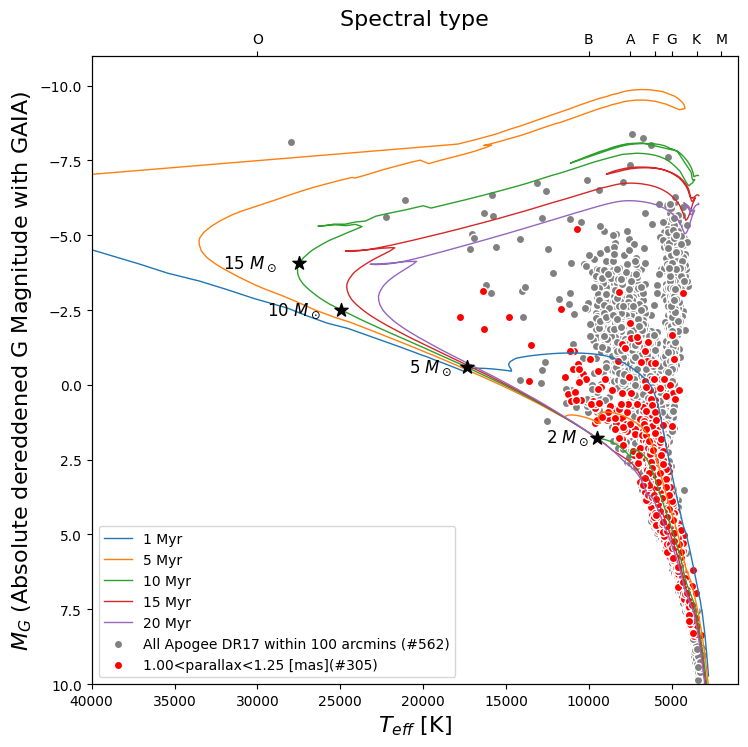

In [133]:
fig, ax = plt.subplots(figsize=(8, 8))

for la in np.unique(ages_iso):
  #For each age la, sel = ages_iso == la filters the data to just that isochrone.
  sel  = ages_iso == la
  order = np.argsort(mass_iso[sel])
  ax.plot(
    Teff_iso[sel][order],
    G_iso[sel][order],
    lw=1,
    label=f"{10**la/1e6:.0f} Myr"
  )

targetAge = 1e7
logAges  = np.unique(ages_iso)
targetLogA = np.log10(targetAge)
la0    = logAges[np.argmin(np.abs(logAges - targetLogA))]
sel0    = ages_iso == la0
# get the *current* mass at 10 Myr
M0   = iso['Mass'][sel0]
Teff0 = Teff_iso[sel0]
G0   = G_iso[sel0]
# sort by Teff
order0 = np.argsort(Teff0)
Teff0 = Teff0[order0]
G0   = G0[order0]
M0   = M0[order0]
# choose which masses to label
targets = [2, 5, 10, 15]  # in M_sun
for target in targets:
  # find the closest point in mass
  idx = np.argmin(np.abs(M0 - target))
  ax.scatter(
    Teff0[idx], G0[idx],
    marker='*', s=100, c='k', zorder=5
  )
  ax.text(
    Teff0[idx] * 1.05, G0[idx],
    f"{M0[idx]:.0f} $M_\\odot$",
    fontsize=12, ha='right', va='center'
  )

ax.set_xlim(1000, 40000) 
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

spectral_temps = [30000, 10000, 7500, 6000, 5000, 3500, 2000]
spectral_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

ax2.set_xticks(spectral_temps)
ax2.set_xticklabels(spectral_types, fontsize=10)
ax2.set_xlabel('Spectral type', labelpad=5, fontsize = 16)
ax2.invert_xaxis()

ax.scatter(teff, dereddened_gmag, color = 'gray', edgecolor = 'w', label = f'All Apogee DR17 within 100 arcmins (#{len(dereddened_gmag_fitted)})')
ax.scatter(subset_teff, subset_dereddened_gmag, color = 'red', edgecolor = 'w', label = f'1.00<parallax<1.25 [mas](#{len(subset_dereddened_gmag_fitted)})')
ax.set_xlabel("$T_{eff}$ [K]", fontsize = 16)
ax.set_ylabel("$M_G$ (Absolute dereddened G Magnitude with GAIA)", fontsize = 16)
ax.tick_params(axis='both', labelsize=10)
ax.set_ylim(-11, 10)
ax.invert_xaxis()
ax.invert_yaxis()
ax.legend(fontsize = 10)
fig.tight_layout()
plt.savefig('dereddened_hr_diagram_gaia.png')
plt.show()